In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sc
from scipy import stats

## **Problème 3** : Simuler une loi de distribution a posteriori avec un algorithme MCMC

Considérons une v.a $X$, suivant une loi de Poisson $\mathcal{P}(\theta)$ où $\theta$ est un paramètre inconnu.

Considérons que la loi de distribution _a priori_ de $\theta$ est une loi Gamma de paramètres fixés et connus $k$ et $\lambda$ : $\mathcal{G}(k, \lambda)$ et de distribution :
$
f(x)=\frac{\lambda}{\Gamma(k)}(\lambda(x-\gamma))^{k-1} \exp [-\lambda(x-\gamma)]
$
Ici, le paramètre $\gamma$ est considéré nul, on a donc :
$
f(x)=\frac{\lambda}{\Gamma(k)}(\lambda x)^{k-1}e^{-\lambda x} \\
<=>
f(x)=x^{k-1}\frac{\lambda^k}{\Gamma(k)}e^{-\lambda x}
$

Prenons $x=10$. La loi a posteriori de $\theta | X = x$ est connue, c'est une loi $\mathcal{G}(k + x, \lambda + 1)$

### 1. Utilisation d'un algorithme MCMC

Dans cette question, nous allons générer un échantillon de ette loi en utilisant le produit de la vraissemblance et du prior avec un algorithme MCMC : __Metropolis Hastings__

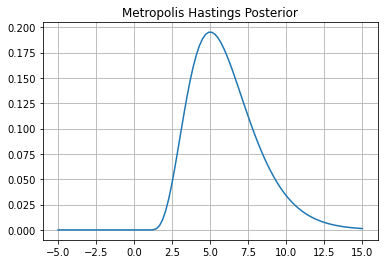

In [16]:
#----------------------------------------------------------------------------------------#
# We know the posterior distribution
k = 5
l = 1

def posterior(x):
    return stats.gamma.pdf(x, k, l)
    # return stats.gamma.pdf(x, k + x, l + 1)

#We want to estimate it and check with the real posterior
def estimated_posterior(x):
    # return stats.gamma.pdf(x, k, l)
    return poisson_likelihood(k, l) * stats.gamma.pdf(x, k, l)
    return poisson_likelihood(k, l) * stats.gamma.pdf(k+x, l+1)

def poisson_likelihood(k, lambd):
    return ((lambd**k) * np.exp(-lambd))/math.factorial(k)
#----------------------------------------------------------------------------------------#
# plot posterior

x_array = np.linspace(-5.0, 15.0, 100)
y_array = np.asarray( [posterior(x) for x in x_array] )

plt.plot(x_array,y_array)

plt.grid()
plt.title('Metropolis Hastings Posterior')
plt.savefig('posterior.png',bbox_inches='tight')
plt.show()
plt.close()

#----------------------------------------------------------------------------------------#
# Metropolis Hastings sampling from the posterior distribution

N = 100000
s = 10

x = 0
p = posterior(x)

samples = []

for i in range(N):
    xn = x + np.random.normal(size=1)
    pn = estimated_posterior(xn)
    if pn >= p:
        p = pn
        x = xn
    else:
        u = np.random.rand()
        if u < pn/p:
            p = pn
            x = xn
    if i % s == 0:
        samples.append(x)

samples = np.array(samples[len(samples)//2::])

plt.scatter(samples, np.zeros_like(samples), s=10)

plt.plot(x_array,y_array)
plt.hist(samples, bins=50,density=1)

plt.title('Metropolis Hastings sampling')
plt.grid()
plt.savefig('metropolis_hastings_1d.png',bbox_inches='tight')
plt.show()
plt.close()
